In [2]:
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import numpy as np
import lightgbm as lgb
from scipy import stats
from catboost import CatBoostClassifier, Pool, cv
from xgboost import XGBClassifier
import random

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

## Importing Data

In [60]:
df = pd.read_csv('/content/Thyroidectomy_readmissions.csv')
label = 'Readmission (1/0)'

for column in df.columns:
  if df[column].dtype == object:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Testing Options
remove_dupplicates = True
feature_engineering = True
weighted_loss = False

In [62]:
# Removing any columns that are not pre or intra operative
columns_to_remove = ['THY_CALCIUM',
    'THY_HYPOCALC30', 'THY_HYPOCALC30_UNK', 'THY_HYPOCALC_EVENT', 'THY_HYPOCALC_EVENTTYPE',
    'THY_LARYNGEAL', 'THY_NECK_HEMATOMA', 'RETURNOR', 'STILLINHOSP',
    'SUPINFEC', 'NWNDINFD', 'ORGSPCSSI', 'DEHIS', 'OUPNEUMO', 'REINTUB',
    'PULEMBOL', 'FAILWEAN', 'RENAINSF', 'OPRENAFL', 'URNINFEC', 'CNSCVA',
    'CDARREST', 'CDMI', 'OTHBLEED', 'OTHDVT', 'OTHSYSEP', 'OTHSESHOCK','REOPERATION1'
    'REOPERATION2', 'REOPERATION3',
    'READMSUSPREASON1', 'READMSUSPREASON2', 'READMSUSPREASON3',
    'READMSUSPREASON4', 'READMSUSPREASON5',
    'READMUNRELSUSP1', 'READMUNRELSUSP2', 'READMUNRELSUSP3',
    'READMUNRELSUSP4', 'READMUNRELSUSP5', 'READMISSION2', 'READMISSION3', 'READMISSION4',
    'READMISSION5', 'READMPODAYS1', 'READMPODAYS2', 'READMPODAYS3',
    'READMPODAYS4', 'READMPODAYS5',
    'UNPLANNEDREADMISSION1', 'UNPLANNEDREADMISSION2', 'UNPLANNEDREADMISSION3',
    'UNPLANNEDREADMISSION4', 'UNPLANNEDREADMISSION5',
    'READMRELATED1', 'READMRELATED2', 'READMRELATED3', 'READMRELATED4',
    'READMRELATED5'
]

# Remove the columns, ignoring any missing columns
df = df.drop(columns=columns_to_remove, errors='ignore')

# Display the updated DataFrame
df.head()

,Age,Calcium,PTH,Creat,TSH,FT4,BP,Pulse,BMI,PACU PTH:,...,PTU,BB,Steroid,Lugol,Adrenal,Thyroid,Parathyroid,Neck,Dissection,Readmission (1/0)
0,16.0,9.1,30.0,0.6,0.280,0.60,122.0,97.0,28.00,7.8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35.0,8.6,51.4,0.6,28.385,0.73,111.0,97.0,32.00,35.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,59.0,9.5,27.2,1.9,0.577,1.08,106.0,74.0,38.00,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,9.5,38.2,0.8,1.282,0.89,120.0,80.0,21.58,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.0,9.2,69.2,1.2,3.351,0.82,106.0,79.0,32.00,32.8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Remove Excess columns

In [69]:
# Remove data which contains more than 30 missing columns, from class 0

if remove_dupplicates == True:
  missing_threshold = 30
  df['missing_features'] = df.isnull().sum(axis=1)
  df = df[(df['missing_features'] < missing_threshold) | (df[label] != 0)]
  df = df.drop('missing_features', axis=1)
  df.dropna(subset=[df.columns[-1]], inplace=True)

print("Total number of Readmissions")
df[label].value_counts()


Total number of Readmissions


,count
Readmission (1/0),
0.0,766
1.0,29


## Feature Engineering


In [70]:
def feature_eng(df):
  if feature_engineering == False:
    return df
  else:
    df['BMI_category'] = pd.cut(df['BMI'],
                                        bins=[0, 18.5, 25, 30, np.inf],
                                        labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

    # 2. Age groups
    df['Age_group'] = pd.cut(df['Age'],
                                      bins=[0, 18, 30, 45, 60, np.inf],
                                      labels=['18', '18-30', '31-45', '46-60', '60+'])

    # 3. Calcium to PTH ratio
    df['Calcium_PTH_ratio'] = df['Calcium'] / df['PTH']

    # 4. TSH to FT4 ratio
    df['TSH_FT4_ratio'] = df['TSH'] / df['FT4']

    # 5. BP categories
    df['BP_category'] = pd.cut(df['BP'],
                                        bins=[0, 120, 130, 140, np.inf],
                                        labels=['Normal', 'Elevated', 'Stage 1', 'Stage 2'])

    # 6. Creatinine clearance (Cockcroft-Gault equation)
    df['Creat_clearance'] = ((140 - df['Age']) * df['BMI']) / (72 * df['Creat'])
    df.loc[df['Gender'] == 0, 'Creat_clearance'] *= 0.85  # Adjust for females

    # 7. TSH * FT4 interaction
    df['TSH_FT4_interaction'] = df['TSH'] * df['FT4']

    # 8. BMI to Age ratio
    df['BMI_Age_ratio'] = df['BMI'] / df['Age']

    # 9. Log transformations
    df['Log_TSH'] = np.log1p(df['TSH'])
    df['Log_PTH'] = np.log1p(df['PTH'])


    # One-hot encode BMI category
    bmi_encoded = pd.get_dummies(df['BMI_category'], prefix='BMI')
    bmi_encoded = bmi_encoded.astype(int)
    df = pd.concat([df, bmi_encoded], axis=1)
    df = df.drop('BMI_category', axis=1)

    age_encoded = pd.get_dummies(df['Age_group'], prefix='Age')
    age_encoded = age_encoded.astype(int)
    df = pd.concat([df, age_encoded], axis=1)
    df = df.drop('Age_group', axis=1)

    bp_encoded = pd.get_dummies(df['BP_category'], prefix='BP')
    bp_encoded = bp_encoded.astype(int)
    df = pd.concat([df, bp_encoded], axis=1)
    df = df.drop('BP_category', axis=1)

    return df


df_eng = feature_eng(df)

In [71]:
# Rename variables and split into train and test

df_eng = df_eng.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


label = (lambda x: re.sub('[^A-Za-z0-9_]+', '', x))(label)
y = df_eng[label]
X = df_eng.drop([label],axis=1)


In [72]:
# Grid search on models

model_to_search = 'lgbm' # 'catboost' or 'lgbm' or 'xg'

if model_to_search == 'catboost':
  model = CatBoostClassifier(
    iterations=500,
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
  )
  param_grid = {
    'depth': [1,2,3,4,5],
    'learning_rate': [0.003,0.01,0.03, 0.1],
    'l2_leaf_reg': [1,2, 3,4, 5]
  }
elif model_to_search == 'lgbm':
  model = lgb.LGBMClassifier(random_state=42, is_unbalance=weighted_loss)
  param_grid = {
    'n_estimators': [50,100, 200],
    'max_depth': [-1,1,2,3],
    'learning_rate': [0.01, 0.1, 0.3],
    'feature_fraction': [0.8,0.9,1.0],
    'bagging_fraction': [0.8,0.9,1.0],
  }
elif model_to_search == 'xg':
  model = XGBClassifier(random_state=42)
  param_grid = {
    'n_estimators': [50,100, 200],
    'max_depth': [-1,1,2,3],
    'learning_rate': [0.01, 0.1, 0.3],
  }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='roc_auc')
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [73]:
# Define models for comparison

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)

lgbm = lgb.LGBMClassifier(random_state=42, bagging_fraction=0.8, feature_fraction= 0.8, learning_rate=0.3, max_depth= 3, n_estimators=100, is_unbalance=weighted_loss, verbosity=-1)
cat = CatBoostClassifier(iterations=1000,
                               learning_rate=0.01,
                               depth=4,
                               l2_leaf_reg=3,
                               loss_function='Logloss',
                               eval_metric='AUC',
                               early_stopping_rounds=50,
                               random_seed=42,
                               verbose=100,
                               class_weights=[0.15,0.85] if weighted_loss else [0.5, 0.5])
xg = XGBClassifier(random_state=42)

# If you did grid serach
# lgbm = best_model
# cat = best_model
# xg = best_model




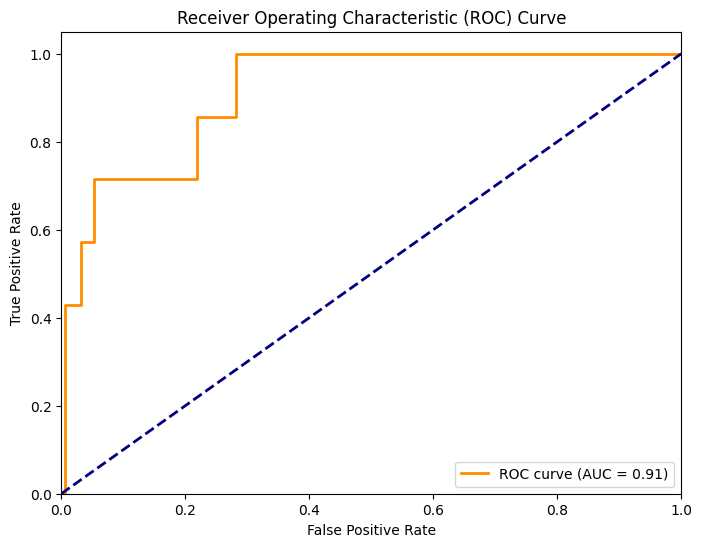

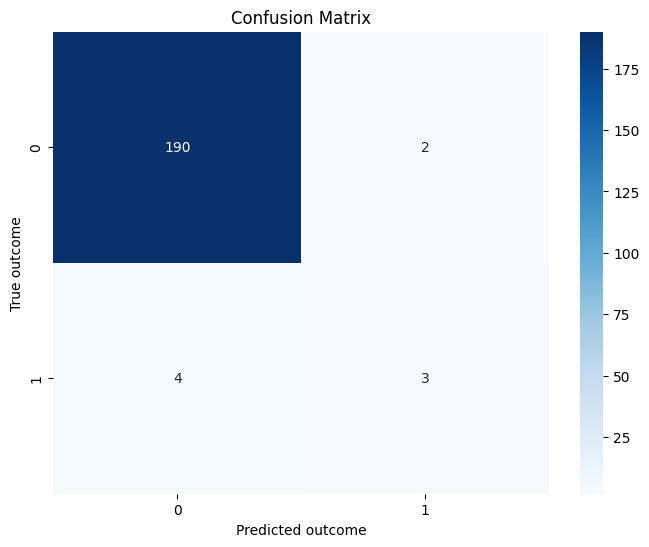




Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       192
         1.0       0.60      0.43      0.50         7

    accuracy                           0.97       199
   macro avg       0.79      0.71      0.74       199
weighted avg       0.97      0.97      0.97       199


Additional Metrics:
Accuracy: 0.9698
Balanced Accuracy: 0.7091
Precision: 0.6000
Recall: 0.4286
F1 Score: 0.5000
AUC-ROC: 0.9144


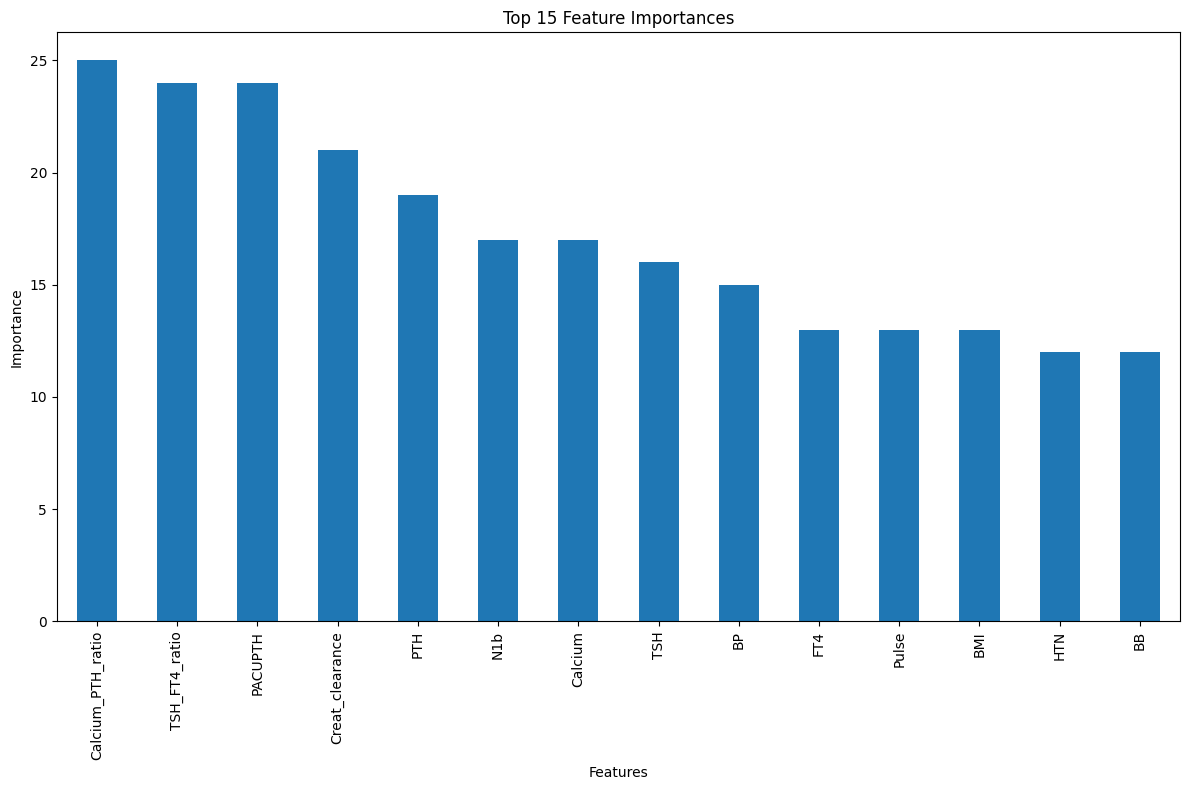


Top Feature Importances:
Calcium_PTH_ratio                   25
TSH_FT4_ratio                       24
PACUPTH                             24
Creat_clearance                     21
PTH                                 19
                                    ..
Thyroiditis                          0
Priorneckirradiation10               0
Priorthyroidparathyroidsurgery10     0
Palpable10                           0
BP_Stage2                            0
Length: 129, dtype: int32


In [74]:
# Test metrics

model = lgbm # xg/cat/lgbm

train_df, test_df = train_test_split(df_eng, test_size=0.25, random_state=69, stratify=df_eng[label])
train_X = train_df.drop([label],axis=1)
train_y = train_df[label]
test_X = test_df.drop([label],axis=1)
test_y = test_df[label]

output = model.fit(train_X, train_y)

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(test_X)
y_pred_proba = model.predict_proba(test_X)[:, 1]
y_pred = (y_pred_proba > 0.03).astype('float')

# Calculate AUC-ROC
fpr, tpr, _ = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print('\n')

# Confusion Matrix
cm = confusion_matrix(test_y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True outcome')
plt.xlabel('Predicted outcome')
plt.show()
print('\n')

# Classification Report
print("\nClassification Report:")
print(classification_report(test_y, y_pred))

# Additional Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_y, y_pred)
balanced_acc = balanced_accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Feature Importance
feature_importance = model.feature_importances_
feature_importance = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_importance[1:15].plot(kind='bar')
plt.title('Top 15 Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop Feature Importances:")
print(feature_importance[1:])

In [64]:
# Averaging across different random states due to size of dataset

model = lgbm #cat/lgbm/xg

def calculate_ci(scores):
    mean = np.mean(scores)
    ci_lower, ci_upper = stats.t.interval(confidence=0.95, df=len(scores)-1,
                                          loc=mean,
                                          scale=stats.sem(scores))
    return mean, ci_lower, ci_upper

all_iteration_scores = []
all_iteration_cis = []

for i in range(30):
    random_state = random.randint(1, 100)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    iteration_scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        lgbm_pred_proba = model.predict_proba(X_val)[:, 1]

        fold_score = roc_auc_score(y_val, lgbm_pred_proba)
        iteration_scores.append(fold_score)

    all_iteration_scores.append(iteration_scores)
    mean_auc, ci_lower, ci_upper = calculate_ci(iteration_scores)
    all_iteration_cis.append((mean_auc, ci_lower, ci_upper))

# Calculate overall statistics
overall_mean = np.mean([ci[0] for ci in all_iteration_cis])
overall_ci_lower = np.mean([ci[1] for ci in all_iteration_cis])
overall_ci_upper = np.mean([ci[2] for ci in all_iteration_cis])

print(f"Average AUC across all iterations: {overall_mean:.4f}")
print(f"Average 95% CI across all iterations: ({overall_ci_lower:.4f}, {overall_ci_upper:.4f})")



Average AUC across all iterations: 0.9134
Average 95% CI across all iterations: (0.8327, 0.9941)
